In [44]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ml_collections import ConfigDict


from sdebridge import sdes
from sdebridge.utils import inverse_fourier, fourier_coefficients
from sdebridge.data_processing import sample_ellipse
from sdebridge import diffusion_bridge


## Unconditional process

In [45]:
def reconstruct_trajectories(diff_coeffs_flatten_traj, initial_shape):
    diff_coeffs_traj = jnp.stack(
        jnp.split(diff_coeffs_flatten_traj, 2, axis=-1),
        axis=-1
    )
    n_pts = initial_shape.shape[-2]
    n_bases = diff_coeffs_traj.shape[-2]
    n_padding = (n_pts - n_bases) // 2
    diff_coeffs_traj_padded = jnp.pad(
        diff_coeffs_traj,
        ((0, 0), (0, 0), (n_padding, n_padding), (0, 0)),
        mode='constant',
        constant_values=0
    )
    diff_coeffs_traj_padded = jnp.fft.ifftshift(diff_coeffs_traj_padded, axes=-2)
    diff_traj_recon = jnp.fft.ifft(diff_coeffs_traj_padded, n=n_pts, axis=-2, norm='backward').real
    traj = diff_traj_recon + initial_shape[None, None, :, :]
    return traj

def plot_trajectories(traj, sample_idx, ax, cmap_name='coolwarm'):
    cmap = colormaps.get_cmap(cmap_name)
    colors = cmap(jnp.linspace(0, 1, traj.shape[-2]))
    for i in range(traj.shape[-2]):
        ax.scatter(traj[sample_idx, 0, i, 0], traj[sample_idx, 0, i, 1], color=colors[i], s=20, marker='o')
        ax.scatter(traj[sample_idx, -10, i, 0], traj[sample_idx, -10, i, 1], color=colors[i], s=20, marker='x')
        ax.plot(traj[sample_idx, :, i, 0], traj[sample_idx, :, i, 1], color=colors[i], alpha=0.3)
    return ax

def hidden_axes(fig, ax):
    fig.add_subplot(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    return ax

In [46]:
n_bases = 16
n_pts = 128
initial_shape = sample_ellipse(n_pts, 0.5)


key = jax.random.PRNGKey(93)

sde_config = {
    'T': 1.0,
    'Nt': 50,
    'dim': 2,
    'n_bases': 4,
    'alpha': 1.0,
    'sigma': 0.1,
    'n_grid': 128,
    'grid_range': (-1.5, 1.5),
    'n_pts': 100}


trajs_bases = []
for n_bases in [8, 16, 24]:
    initial_coeffs = fourier_coefficients(initial_shape, n_bases)
    sde_config['n_bases'] = n_bases
    sde = sdes.fourier_gaussian_kernel_sde(**sde_config)
    traj_coeffs = sdes.simulate_traj(sde, initial_coeffs, 2, key)
    traj = inverse_fourier(traj_coeffs, 120)
    trajs_bases.append(traj)

In [47]:
trajs_sigma = []
n_bases = 16
sde_config['n_bases'] = n_bases

for sigma in [0.1, 0.5, 1.0]:
    sde_config['sigma'] = sigma
    initial_coeffs = fourier_coefficients(initial_shape, n_bases)
    sde = sdes.fourier_gaussian_kernel_sde(**sde_config)
    traj_coeffs = sdes.simulate_traj(sde, initial_coeffs, 2, key)
    traj = inverse_fourier(traj_coeffs, 120)
    trajs_sigma.append(traj)

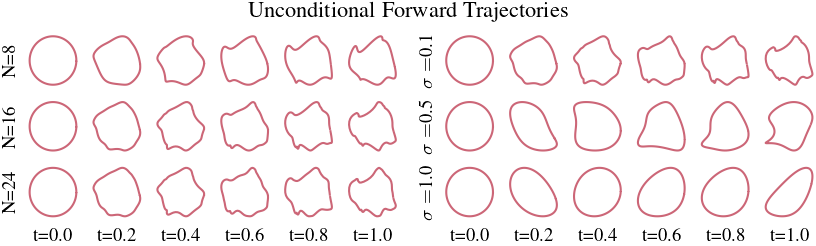

In [48]:
from sdebridge.plotting import set_style
from tueplots import axes, bundles, cycler, figsizes, fonts
from tueplots.constants.color import palettes

plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2024(nrows=1, ncols=2, usetex=True))
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))
plt.rcParams.update(axes.lines())
plt.rcParams.update(axes.spines(top=False, right=False))
        
fig = plt.figure(constrained_layout=True)
fig.suptitle(r"Unconditional Forward Trajectories")

subfigs = fig.subfigures(1, 2)
basis_fig = subfigs[0]
sigma_fig = subfigs[1]

ax = basis_fig.subplots(3, 6)
for i in range(3):
    ax[i, 0].plot(trajs_bases[i][0, 0, :, 0], trajs_bases[i][0, 0, :, 1])
    hidden_axes(basis_fig, ax[i, 0])
    for j in range(1, 6):
        ax[i, j].plot(trajs_bases[i][0, 10*j-1, :, 0], trajs_bases[i][0, 10*j-1, :, 1])
        hidden_axes(basis_fig, ax[i, j])
for i in range(6):
    ax[2, i].set_xlabel(fr"t={i*0.2:.1f}")

for j in range(3):
    ax[j, 0].set_ylabel(fr"N={j*8+8}")
# basis_fig.suptitle(
#     r"Unconditional Forward Trajectories"
# )

ax = sigma_fig.subplots(3, 6)
# sigma_fig.suptitle(r"Unconditional Forward Trajectories")

for i in range(3):
    ax[i, 0].plot(trajs_sigma[i][0, 0, :, 0], trajs_sigma[i][0, 0, :, 1])
    hidden_axes(sigma_fig, ax[i, 0])
    for j in range(1, 6):
        ax[i, j].plot(trajs_sigma[i][0, 10*j-1, :, 0], trajs_sigma[i][0, 10*j-1, :, 1])
        hidden_axes(sigma_fig, ax[i, j])
for i in range(6):
    ax[2, i].set_xlabel(fr"t={i*0.2:.1f}")


for j, sigma in enumerate([0.1, 0.5, 1.0]):
    ax[j, 0].set_ylabel(fr"$\sigma=${sigma}")


In [49]:
fig.savefig("../figures/unconditional_trajs.pdf", dpi=150)

### Visualization of bridges

In [50]:
### load butterfly data
initial_butterfly = jnp.load('../data/tom_pts.npy')
target_butterfly = jnp.load('../data/honrathi_pts.npy')
print(initial_butterfly.shape, target_butterfly.shape)

(120, 2) (120, 2)


TypeError: plot_butterfly_traj_pts() missing 1 required positional argument: 'init'

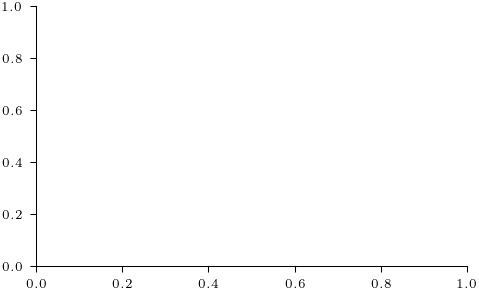

In [51]:
from sdebridge.plotting import plot_butterfly_traj_pts, set_style
import matplotlib.pyplot as plt
import jax.numpy as jnp
from matplotlib import colormaps

set_style()
backward_traj = jnp.load("../plots_data/backward_traj.npy")

fig, ax = plt.subplots(1, 1)
plot_butterfly_traj_pts(traj=backward_traj, sample_idx=0, ax=ax, cmap_name="coolwarm")
fig.savefig("../figures/bridge_visualization.pdf", dpi=150)

In [52]:
# from sdebridge.plotting import plot_butterfly_traj_pts, set_style
# import matplotlib.pyplot as plt
# import jax.numpy as jnp
# 
# set_style("full", 1, 6)
# backward_traj = jnp.load("../plots_data/backward_traj.npy")
# 
# backward_traj_mean = jnp.mean(backward_traj, axis=0)
# backward_traj_std = jnp.std(backward_traj, axis=0)
# backward_traj_err = jnp.sqrt(backward_traj_std[..., 0]**2 + backward_traj_std[..., 1]**2)
# print(backward_traj_mean.shape, backward_traj_err.shape)
# 
# def draw_error_band(ax, x, y, err, **kwargs):
#     # Calculate normals via centered finite differences (except the first point
#     # which uses a forward difference and the last point which uses a backward
#     # difference).
#     dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
#     dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
#     l = np.hypot(dx, dy)
#     nx = dy / l
#     ny = -dx / l
# 
#     # end points of errors
#     xp = x + nx * err
#     yp = y + ny * err
#     xn = x - nx * err
#     yn = y - ny * err
# 
#     vertices = np.block([[xp, xn[::-1]],
#                          [yp, yn[::-1]]]).T
#     codes = np.full(len(vertices), Path.LINETO)
#     codes[0] = codes[len(xp)] = Path.MOVETO
#     path = Path(vertices, codes)
#     ax.add_patch(PathPatch(path, **kwargs))
# 
# fig, ax = plt.subplots(1, 6)
# for i in range(6):
#     ax[i].plot(backward_traj_mean[i*10, :, 0], backward_traj_mean[i*10, :, 1], color='r')
#     draw_error_band(ax[i], backward_traj_mean[i*10, :, 0], backward_traj_mean[i*10, :, 1], backward_traj_err[i*10, :], edgecolor='none', alpha=0.3)
#     ax[i].set_title(fr"t={i*0.2:.1f}")
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])
#     ax[i].set_frame_on(False)
# 
# # fig.savefig("../figures/bridge_visualization_error_band.png", dpi=100, bbox_inches='tight')

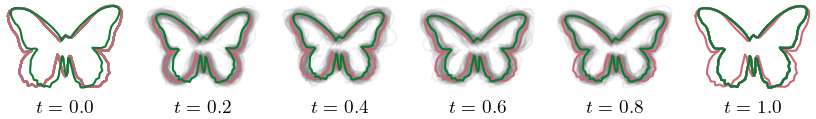

In [64]:
from sdebridge.plotting import plot_butterfly_traj_pts, set_style, add_start_to_end
import matplotlib.pyplot as plt
import jax.numpy as jnp
from matplotlib import colormaps
import tueplots.figsizes


plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2024(nrows=1.5, ncols=6, usetex=True))
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))
plt.rcParams.update(axes.lines())
plt.rcParams.update(axes.spines(top=False, right=False))
backward_traj = jnp.load("../plots_data/backward_traj.npy")
backward_traj = add_start_to_end(backward_traj)

# backward_traj_mean = jnp.mean(backward_traj, axis=0)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1, 6)
for i in range(6):
    color=cycle[1]
    # cmap = colormaps.get_cmap("viridis")
    # colors = cmap(jnp.linspace(0, 1, backward_traj.shape[0]))
    time = i*10
    for traj in range(backward_traj.shape[0]):
        ax[i].plot(backward_traj[traj, time, :, 0], backward_traj[traj, time, :, 1], alpha=0.1, color='grey')
    ax[i].plot(backward_traj[traj, 0, :, 0], backward_traj[traj, 0, :, 1], alpha=1., color=cycle[0])
    ax[i].plot(backward_traj[traj, -1, :, 0], backward_traj[traj, -1, :, 1], alpha=1., color=cycle[3])
    # ax[i].plot(backward_traj_mean[time, :, 0], backward_traj_mean[time, :, 1], color=color)
    # ax[i].set_title(fr"$t={i*0.2:.1f}$")
    ax[i].set_xlabel(fr"$t={i*0.2:.1f}$")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_frame_on(False)

fig.savefig("../figures/bridge_visualization_error_band.pdf", dpi=150)

### Covariance matrices

In [54]:
# def gaussian_kernel_2d(x: jnp.ndarray, y: jnp.ndarray, alpha: float, sigma: float) -> jnp.ndarray:
#     return alpha * jnp.exp(-jnp.linalg.norm(x - y, axis=-1) ** 2 / (2 * sigma ** 2))
# 
# def landmark_covariance(lmks_diff, init_shape, alpha, sigma, n_grid):
#     n_pts = init_shape.shape[0]
#     grid = jnp.linspace(-1.0, 1.0, n_grid)
#     grid = jnp.stack(jnp.meshgrid(grid, grid, indexing='xy'), axis=-1)
#     curr_shape = init_shape + lmks_diff
#     Q = jax.vmap(
#         jax.vmap(
#             jax.vmap(
#                 partial(gaussian_kernel_2d, alpha=alpha, sigma=sigma),
#                 in_axes=(None, 0),
#                 out_axes=0
#             ),
#             in_axes=(None, 1),
#             out_axes=1
#         ),
#         in_axes=(0, None),
#         out_axes=0
#     )(curr_shape, grid)
#     Q = Q.reshape(n_pts, n_grid**2)
#     return jnp.matmul(Q, Q.T)
# 
# def coefficient_covariance(coeffs_diff, init_shape, alpha, sigma, n_grid):
#     n_pts = init_shape.shape[0]
#     n_bases = coeffs_diff.shape[0]
#     n_padding = (n_pts - n_bases) // 2
#     grid = jnp.linspace(-1.0, 1.0, n_grid)
#     grid = jnp.stack(jnp.meshgrid(grid, grid, indexing='xy'), axis=-1)
# 
#     base_fn = lambda freq: jnp.exp(1j * jnp.arange(-n_pts//2, n_pts//2) * freq)
#     freqs = jnp.fft.fftshift(
#         jnp.fft.fftfreq(n_bases, d=1/(2.0*jnp.pi))
#     )
#     basis = jax.vmap(base_fn)(freqs)
# 
#     def eval_coeffs(coeffs):
#         coeffs = coeffs / jnp.sqrt(n_pts)
#         coeffs = jnp.pad(coeffs, ((n_padding, n_padding), (0, 0)))
#         return jnp.matmul(basis, coeffs) / jnp.sqrt(n_pts)
#     
#     def eval_shape(shape):
#         shape_coeffs = jnp.fft.fft(shape, n=n_pts, axis=0) / jnp.sqrt(n_pts)
#         shape_coeffs = jnp.fft.fftshift(shape_coeffs, axes=0)
#         return jnp.matmul(basis, shape_coeffs) / jnp.sqrt(n_pts)
#     
#     init_shape_eval = eval_shape(init_shape)
#     coeffs_eval = eval_coeffs(coeffs_diff)
#     curr_shape_eval = init_shape_eval + coeffs_eval
# 
#     Q = jax.vmap(
#         jax.vmap(
#             jax.vmap(
#                 partial(gaussian_kernel_2d, alpha=alpha, sigma=sigma),
#                 in_axes=(None, 0),
#                 out_axes=0
#             ),
#             in_axes=(None, 1),
#             out_axes=1
#         ),
#         in_axes=(0, None),
#         out_axes=0
#     )(curr_shape_eval, grid)
#     Q = Q.reshape(n_bases, n_grid**2)
#     return jnp.matmul(Q, Q.T)

In [ ]:
# diff = target_butterfly - initial_butterfly
# lmk_cov = landmark_covariance(diff[::2, :], initial_butterfly[::2, :], 1.0, 0.2, 64)

In [ ]:
# plt.imshow(lmk_cov)
# plt.colorbar()

In [ ]:
# diff_coeff = jnp.fft.fft(diff, axis=0)
# diff_coeff = jnp.fft.fftshift(diff_coeff, axes=0)
# diff_coeff = diff_coeff[(diff_coeff.shape[0] - 60) // 2 : (diff_coeff.shape[0] + 60) // 2, :]
# coeff_cov = coefficient_covariance(diff_coeff, initial_butterfly, 1.0, 0.2, 64)

In [ ]:
# plt.imshow(coeff_cov)
# plt.colorbar()

### Score evolution

In [ ]:
# @partial(jax.jit, backend='gpu')
# def inference_score_coeffs(X_coeffs, time, state):
#     score_output = state.apply_fn(
#         {"params": state.params, "batch_stats": state.batch_stats},
#         x_complex=X_coeffs,
#         t=time,
#         train=False
#     )
#     score_real, score_imag = jnp.split(score_output, 2, axis=-1)
#     score_coeffs = score_real + 1j * score_imag
#     return score_coeffs
# 
# def evaluate_score(score_coeffs, n_pts):
#     n_bases = score_coeffs.shape[0]
#     n_padding = (n_pts - n_bases) // 2
# 
#     score_coeffs = jnp.pad(score_coeffs, ((n_padding, n_padding), (0, 0)))
#     score_coeffs = jnp.fft.ifftshift(score_coeffs, axes=0)
#     score_eval = jnp.fft.ifft(score_coeffs, n=n_pts, axis=0, norm='backward').real
#     return score_eval
# 
# def simulate(state, n_bases, initial_shape, target_shape):
#     n_pts = initial_shape.shape[0]
# 
#     sde_config = ConfigDict(
#         {
#             'init_S': initial_shape,
#             'n_bases': n_bases,
#             'n_grid': 64,
#             'grid_range': [-1.5, 1.5],
#             'alpha': 1.0,
#             'sigma': 0.1,
#             'T': 1.0,
#             'N': 50,
#             'dim': 2
#         }
#     )
# 
#     sde = FourierGaussianKernelSDE(sde_config)
#     bridge = DiffusionBridge(sde)
# 
#     initial_diff_coeffs = jnp.zeros((n_bases, 2), dtype=jnp.complex64)
#     target_diff = target_shape - initial_shape
#     target_diff_coeffs = jnp.fft.fft(target_diff, n=n_pts, axis=0, norm='backward')
#     target_diff_coeffs = jnp.fft.fftshift(target_diff_coeffs, axes=0)   # shift zero freqency to center for truncation
#     target_diff_coeffs = target_diff_coeffs[
#         (n_pts - n_bases) // 2: (n_pts + n_bases) // 2, :
#     ]   # truncate low frequencies
# 
#     initial_diff_flatten = jnp.concatenate(
#         [initial_diff_coeffs[:, 0], initial_diff_coeffs[:, 1]],
#         axis=0
#     )
#     target_diff_flatten = jnp.concatenate(
#         [target_diff_coeffs[:, 0], target_diff_coeffs[:, 1]],
#         axis=0
#     )
# 
#     score_p = lambda val, time: partial(inference_score_coeffs, state=state)(val, time)
#     backward_X_coeffs_bridge = bridge.simulate_backward_bridge(
#         initial_val=initial_diff_flatten,
#         terminal_val=target_diff_flatten,
#         score_p=score_p,
#         num_batches=1,
#     )
#     
#     backward_X_coeffs_bridge_traj = backward_X_coeffs_bridge["trajectories"]
#     backward_traj = reconstruct_trajectories(
#         backward_X_coeffs_bridge_traj,
#         initial_shape
#     )
# 
#     score_evals = []
#     for i in range(6):
#         score_coeffs = inference_score_coeffs(backward_X_coeffs_bridge_traj[0, i*10, :], jnp.array([i*0.2]), state)
#         score_coeffs = jnp.squeeze(score_coeffs)
#         score_coeffs = jnp.stack(jnp.split(score_coeffs, 2, axis=-1), axis=-1)
#         score_eval = evaluate_score(score_coeffs, initial_shape.shape[0])
#         score_evals.append(score_eval)
#     score_evals = jnp.stack(score_evals, axis=0)
#     return backward_traj, score_evals

In [ ]:
# score_p_state_8 = load_ckpts('./ckpts/score_p_8_bases')
# score_p_state_16 = load_ckpts('./ckpts/score_p_16_bases')
# score_p_state_24 = load_ckpts('./ckpts/score_p_24_bases_retrain')

In [ ]:
# backward_bridge_traj_8, score_evals_8 = simulate(score_p_state_8, 8, initial_butterfly, target_butterfly)
# backward_bridge_traj_16, score_evals_16 = simulate(score_p_state_16, 16, initial_butterfly, target_butterfly)
# backward_bridge_traj_24, score_evals_24 = simulate(score_p_state_24, 24, initial_butterfly, target_butterfly)

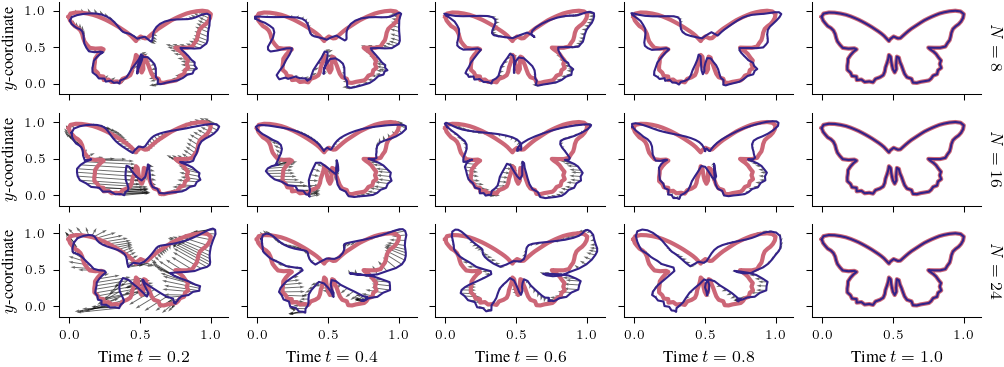

In [4]:
from sdebridge.plotting import plot_butterfly_traj_pts, set_style, add_start_to_end
from matplotlib import colormaps
import matplotlib.pyplot as plt
import jax.numpy as jnp

set_style("full", 3, 5)

backward_traj_8 = jnp.load("../plots_data/backward_traj_8.npy")
backward_traj_16 = jnp.load("../plots_data/backward_traj_16.npy")
backward_traj_24 = jnp.load("../plots_data/backward_traj_24.npy")

backward_traj_8 = add_start_to_end(backward_traj_8)
backward_traj_16 = add_start_to_end(backward_traj_16)
backward_traj_24 = add_start_to_end(backward_traj_24)


score_evals_8 = jnp.load("../plots_data/score_evals_8.npy")
score_evals_16 = jnp.load("../plots_data/score_evals_16.npy")
score_evals_24 = jnp.load("../plots_data/score_evals_24.npy")

score_evals_8 = add_start_to_end(score_evals_8)
score_evals_16 = add_start_to_end(score_evals_16)
score_evals_24 = add_start_to_end(score_evals_24)


def plot_score_grid():
    fig, ax = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True)

    ax[0, -1].set_ylabel("$N=8$", rotation=270, labelpad=10)
    ax[0, -1].yaxis.set_label_position("right")
    ax[0, 0].set_ylabel("$y$-coordinate", fontsize="medium")

    ax[1, -1].set_ylabel("$N=16$", rotation=270, labelpad=10)
    ax[1, -1].yaxis.set_label_position("right")
    ax[1, 0].set_ylabel("$y$-coordinate", fontsize="medium")

    ax[2, -1].set_ylabel("$N=24$", rotation=270, labelpad=10)
    ax[2, -1].yaxis.set_label_position("right")
    ax[2, 0].set_ylabel("$y$-coordinate", fontsize="medium")

    ax[2, 0].set_xlabel("$x$-coordinate", fontsize="medium")
    ax[2, 1].set_xlabel("$x$-coordinate", fontsize="medium")
    ax[2, 2].set_xlabel("$x$-coordinate", fontsize="medium")
    ax[2, 3].set_xlabel("$x$-coordinate", fontsize="medium")

    ax[2, 0].set_xlabel("Time $t=0.2$")
    ax[2, 1].set_xlabel(fr"Time $t=0.4$")
    ax[2, 2].set_xlabel(fr"Time $t=0.6$")
    ax[2, 3].set_xlabel(fr"Time $t=0.8$")
    ax[2, 4].set_xlabel("Time $t=1.0$")
        
    def plot_row(traj, score, axs, row, col):
        time = (col+1)*10
        axs[row, col].set_xticks((0., 0.5, 1.))
        axs[row, col].set_yticks((0., 0.5, 1.))
        
        axs[row, col].plot(traj[0, -1, :, 0], traj[0, -1, :, 1], linewidth=2.0)
        axs[row, col].plot(traj[0, time, :, 0], traj[0, time, :, 1])

        axs[row, col].quiver(
            traj[0, time, :, 0],
            traj[0, time, :, 1],
            score[col+1, :, 0],
            score[col+1, :, 1],
            alpha=0.6, angles='xy', scale_units='xy', scale=0.3
        )
        return axs

    for i in range(5):
        plot_row(backward_traj_8, score_evals_8, ax, 0, i)
        plot_row(backward_traj_16, score_evals_16, ax, 1, i)
        plot_row(backward_traj_24, score_evals_24, ax, 2, i)

    fig.align_ylabels()
    fig.align_xlabels()
    return fig, ax

fig, ax = plot_score_grid()
plt.savefig("../figures/butterfly_grid.pdf", dpi=150)

In [12]:
from sdebridge.plotting import plot_butterfly_traj_pts, set_style, add_start_to_end
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

ambrax_traj = np.load('../data/papilonidae_traj/bwd_traj_ambrax.npy')[0]
deiphobus_traj = np.load('../data/papilonidae_traj/bwd_traj_deiphobus.npy')[0]
protenor_traj = np.load('../data/papilonidae_traj/bwd_traj_protenor.npy')[0]
phestus_traj = np.load('../data/papilonidae_traj/bwd_traj_phestus.npy')[0]
polytes_traj = np.load('../data/papilonidae_traj/bwd_traj_polytes.npy')[0]

trajs = [ambrax_traj, deiphobus_traj, protenor_traj, phestus_traj, polytes_traj]

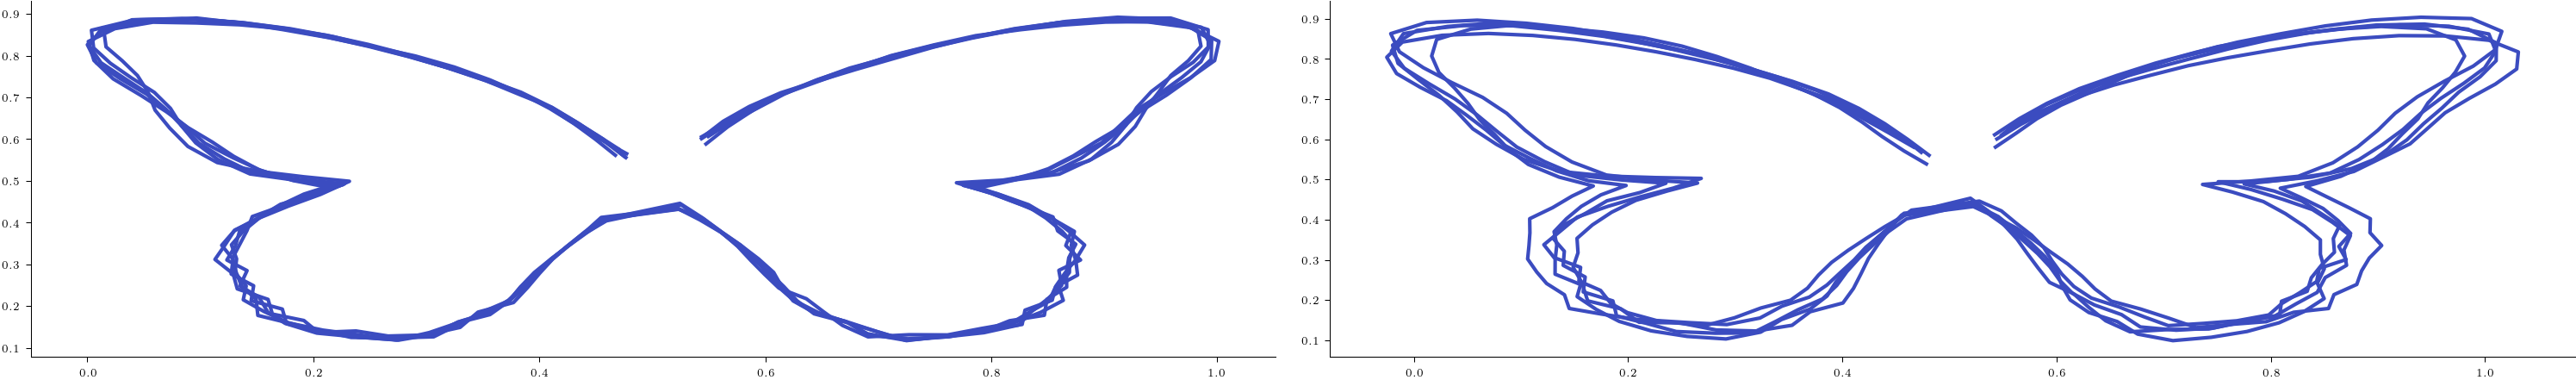

In [13]:
cmap = colormaps.get_cmap("coolwarm")
colors = cmap(np.linspace(0, 1, 6))
alpha = 0.7

fig, ax = plt.subplots(1, 2, figsize=(20, 3))

for traj in trajs:
    ax[0].plot(traj[0, :, 0], traj[0, :, 1], color=colors[0], linewidth=2)
    ax[1].plot(traj[-1, :, 0], traj[-1, :, 1], color=colors[0], linewidth=2)

KeyboardInterrupt: 

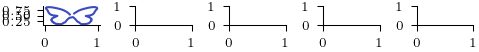

In [18]:
set_style(nrows=1, ncols=5)

cmap = colormaps.get_cmap("coolwarm")
colors = cmap(np.linspace(0, 1, 6))
alpha = 0.7
linewidth = 1

fig, ax = plt.subplots(1, 5)

# Mean shape is 0th elt.

shift = jnp.linspace(0, 1, trajs[0].shape[0])

ax[0].plot(ambrax_traj[0, :, 0], ambrax_traj[0, :, 1], color=colors[0], label="$t=0$", linewidth=linewidth)
for i in range(1, 5):
    ax[0].plot(ambrax_traj[i*10-1, :, 0], ambrax_traj[i*10-1, :, 1], color=colors[i], alpha=alpha, label=f"$t={i*0.2:.1f}$")
ax[0].plot(ambrax_traj[-1, :, 0], ambrax_traj[-1, :, 1], color=colors[-1], label="$t=1$")

for i, traj in enumerate(trajs):
    ax[i].plot(traj[0, :, 0], traj[0, :, 1], color=colors[0], linewidth=linewidth)
    
    for j in range(1, 5):
        ax[i].plot(traj[j*10-1, :, 0], traj[j*10-1, :, 1], color=colors[j], alpha=alpha)
        
    ax[i].plot(traj[-1, :, 0], traj[-1, :, 1], color=colors[-1], linewidth=linewidth)
    

ax[0].set_title("Ambrax")
ax[1].set_title("Deiphobus")
ax[2].set_title("Protenor")
ax[3].set_title("Phestus")
ax[4].set_title("Polytes")

# add legend for the big plot
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=6, frameon=False)

for i in range(5):
    ax[i].set_axis_off()

plt.savefig("../figures/mean_butterflies.pdf", dpi=150)

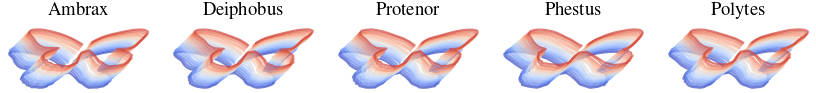

In [43]:
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2024(nrows=1, ncols=5, usetex=True))
# plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))
plt.rcParams.update(axes.lines())
plt.rcParams.update(axes.spines(top=False, right=False))

cmap = colormaps.get_cmap("coolwarm")
colors = cmap(np.linspace(0, 1, trajs[0].shape[0]))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))

alpha = 0.7
linewidth = 1

fig, ax = plt.subplots(1, 5)

# Mean shape is 0th elt.

shift = jnp.linspace(0, 1, trajs[0].shape[0])

for i, traj in enumerate(trajs):
    for k in range(traj.shape[0]//3):
        j=3*k
        ax[i].plot(traj[j, :, 0]+0.2*shift[j], traj[j, :, 1]+0.5*shift[j], alpha=alpha, color=colors[j], linewidth=linewidth)
            

ax[0].set_title("Ambrax")
ax[1].set_title("Deiphobus")
ax[2].set_title("Protenor")
ax[3].set_title("Phestus")
ax[4].set_title("Polytes")

# add legend for the big plot
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=6, frameon=False)
# fig.colorbar(sm, ax=ax[0])

for i in range(5):
    ax[i].set_axis_off()

plt.savefig("../figures/mean_butterflies.pdf", dpi=150)